In [1]:
%matplotlib notebook

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from itertools import product, combinations

In [2]:
# transmit power = -8 dbm
# advertising interval = 100 ms

beacons = ['fa8f382a88f1',
           'c58af3c68f77',
           '181df55c397f',
           '9efb0dc4a4eb',
           '4ecf9feb4675',
           'b2b41678058b',
           'd3b9b43f91d4',
           'dbdaf9db4e4b']

In [3]:
# define vertices of the room
bottom = np.array(((0, 0, 0), (0, 4.3942, 0), (-0.254, 4.3942, 0), (-0.254, 6.25, 0), (5.7658, 6.25, 0), (5.7658, 5.7928, 0), (6.1722, 5.7928, 0), (6.1722, 0, 0), (0, 0, 0)))
bottom

array([[ 0.    ,  0.    ,  0.    ],
       [ 0.    ,  4.3942,  0.    ],
       [-0.254 ,  4.3942,  0.    ],
       [-0.254 ,  6.25  ,  0.    ],
       [ 5.7658,  6.25  ,  0.    ],
       [ 5.7658,  5.7928,  0.    ],
       [ 6.1722,  5.7928,  0.    ],
       [ 6.1722,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ]])

In [4]:
df1 = pd.read_csv("CSV_20200922_v2.csv", names=['rp', 'time', 'uid', 'rssi'])
df1['time'] = pd.to_datetime(df1['time'], format="%H:%M:%S:%f")
df1['rssi'] = df1['rssi'].astype(int)
df1

,rp,time,uid,rssi
0,R01C01-A,1900-01-01 16:50:10.491,181df55c397f,-73
1,R01C01-A,1900-01-01 16:50:10.511,181df55c397f,-73
2,R01C01-A,1900-01-01 16:50:10.511,d3b9b43f91d4,-76
3,R01C01-A,1900-01-01 16:50:10.557,181df55c397f,-73
4,R01C01-A,1900-01-01 16:50:10.557,d3b9b43f91d4,-76
...,...,...,...,...
57255,R03C11-D,1900-01-01 17:40:00.689,c58af3c68f77,-70
57256,R03C11-D,1900-01-01 17:40:00.689,4ecf9feb4675,-74
57257,R03C11-D,1900-01-01 17:40:00.689,b2b41678058b,-73
57258,R03C11-D,1900-01-01 17:40:00.689,fa8f382a88f1,-70


In [5]:
df2 = pd.read_csv("CSV_20200924.csv", names=['rp', 'time', 'uid', 'rssi'])
df2['time'] = pd.to_datetime(df2['time'], format="%H:%M:%S:%f")
df2['rssi'] = df2['rssi'].astype(int)
df2

,rp,time,uid,rssi
0,R05C03-A,1900-01-01 14:36:04.739,9efb0dc4a4eb,-69
1,R05C03-A,1900-01-01 14:36:04.759,9efb0dc4a4eb,-69
2,R05C03-A,1900-01-01 14:36:04.759,d3b9b43f91d4,-79
3,R05C03-A,1900-01-01 14:36:04.763,9efb0dc4a4eb,-69
4,R05C03-A,1900-01-01 14:36:04.763,d3b9b43f91d4,-79
...,...,...,...,...
104198,R11C11-D,1900-01-01 16:10:44.446,b2b41678058b,-76
104199,R11C11-D,1900-01-01 16:10:44.446,c58af3c68f77,-71
104200,R11C11-D,1900-01-01 16:10:44.446,fa8f382a88f1,-73
104201,R11C11-D,1900-01-01 16:10:44.446,d3b9b43f91d4,-74


In [6]:
df = pd.concat([df1, df2], axis=0)
df = df.reset_index(drop=True)
df

,rp,time,uid,rssi
0,R01C01-A,1900-01-01 16:50:10.491,181df55c397f,-73
1,R01C01-A,1900-01-01 16:50:10.511,181df55c397f,-73
2,R01C01-A,1900-01-01 16:50:10.511,d3b9b43f91d4,-76
3,R01C01-A,1900-01-01 16:50:10.557,181df55c397f,-73
4,R01C01-A,1900-01-01 16:50:10.557,d3b9b43f91d4,-76
...,...,...,...,...
161458,R11C11-D,1900-01-01 16:10:44.446,b2b41678058b,-76
161459,R11C11-D,1900-01-01 16:10:44.446,c58af3c68f77,-71
161460,R11C11-D,1900-01-01 16:10:44.446,fa8f382a88f1,-73
161461,R11C11-D,1900-01-01 16:10:44.446,d3b9b43f91d4,-74


In [7]:
rssi_db = {}
grid_size = 0.4492625
R01C01 = (0.7906, 5.9166)

for entry in df.rp.unique():
    match = re.search(r'R([0-9]+)C([0-9]+)', entry)
    rp = match.group()
    direction = entry.replace(rp, "")
    if rp not in rssi_db.keys():
        match_row = re.search(r'R[0-9]+', rp)
        match_col = re.search(r'C[0-9]+', rp)

        rssi_db[rp] = {}
        rssi_db[rp]['x'] = R01C01[0] + (int(match_col.group().replace('C', '')) - 1) * grid_size
        rssi_db[rp]['y'] = R01C01[1] - (int(match_row.group().replace('R', '')) - 1) * grid_size
    
    rssi_db[rp][direction] = 0

rssi_db

{'R01C01': {'x': 0.7906, 'y': 5.9166, '-A': 0, '-B': 0, '-C': 0, '-D': 0},
 'R01C03': {'x': 1.689125, 'y': 5.9166, '-A': 0, '-B': 0, '-C': 0, '-D': 0},
 'R01C05': {'x': 2.58765, 'y': 5.9166, '-A': 0, '-B': 0, '-C': 0, '-D': 0},
 'R01C07': {'x': 3.486175, 'y': 5.9166, '-A': 0, '-B': 0, '-C': 0, '-D': 0},
 'R03C01': {'x': 0.7906, 'y': 5.018075, '-A': 0, '-B': 0, '-C': 0, '-D': 0},
 'R03C03': {'x': 1.689125, 'y': 5.018075, '-A': 0, '-B': 0, '-C': 0, '-D': 0},
 'R03C05': {'x': 2.58765, 'y': 5.018075, '-A': 0, '-B': 0, '-C': 0, '-D': 0},
 'R03C07': {'x': 3.486175, 'y': 5.018075, '-A': 0, '-B': 0, '-C': 0, '-D': 0},
 'R03C09': {'x': 4.3847000000000005,
  'y': 5.018075,
  '-A': 0,
  '-B': 0,
  '-C': 0,
  '-D': 0},
 'R03C11': {'x': 5.283225, 'y': 5.018075, '-A': 0, '-B': 0, '-C': 0, '-D': 0},
 'R05C03': {'x': 1.689125, 'y': 4.11955, '-A': 0, '-B': 0, '-C': 0, '-D': 0},
 'R05C05': {'x': 2.58765, 'y': 4.11955, '-A': 0, '-B': 0, '-C': 0, '-D': 0},
 'R05C07': {'x': 3.486175, 'y': 4.11955, '-A': 0,

<IPython.core.display.Javascript object>


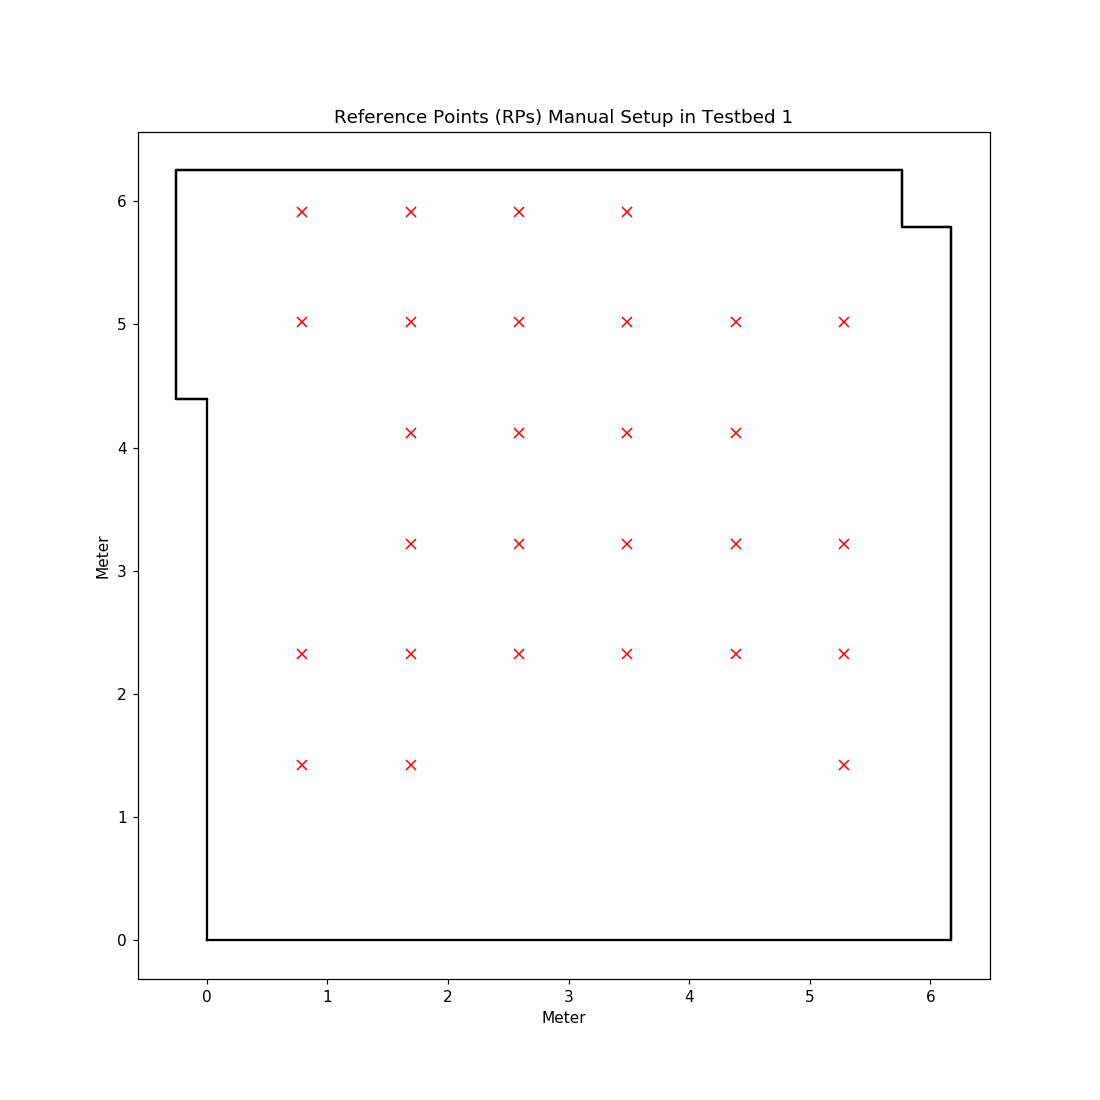

In [8]:
#for i in range(len(bottom) - 1):

fig,ax = plt.subplots(figsize=(10, 10))

walls_x_2d = [(bottom[i][0], bottom[i + 1][0]) for i in np.arange(len(bottom) - 1)]
walls_y_2d = [(bottom[i][1], bottom[i + 1][1]) for i in np.arange(len(bottom) - 1)]

ax.set_xlabel("Meter")
ax.set_ylabel("Meter")
ax.set_title("Reference Points (RPs) Manual Setup in Testbed 1")
ax.plot(walls_x_2d, walls_y_2d, '-k')

for rp in rssi_db.keys():
    ax.plot(rssi_db[rp]['x'], rssi_db[rp]['y'], marker='x', color='red')
#     plt.text(rssi_db[rp]['x'], rssi_db[rp]['y'] + 0.05, rp, fontsize = 6)

plt.show()

fig.savefig("RPs_manual.png", dpi=300)

# Coordinate Conversion

In [ ]:
from numpy import *
from math import sqrt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


def rigid_transform_3D(A, B):
    assert len(A) == len(B)
    N = A.shape[0];
    mu_A = mean(A, axis=0)
    mu_B = mean(B, axis=0)

    AA = A - tile(mu_A, (N, 1))
    BB = B - tile(mu_B, (N, 1))
    H = transpose(AA) * BB

    U, S, Vt = linalg.svd(H)
    R = Vt.T * U.T

    if linalg.det(R) < 0:
        print("Reflection detected")
        Vt[2, :] *= -1
        R = Vt.T * U.T

    t = -R * mu_A.T + mu_B.T

    return R, t

In [ ]:
R

In [ ]:
R = mat(random.rand(3,3))
t = mat(random.rand(3,1))

U,S,Vt = linalg.svd(R)
R = U*Vt
if linalg.det(R) < 0:
    Vt[2,:]*=-1
    R = U*Vt

n = 1

A = mat(random.rand(n,3))
B = R*A.T + tile(t,(1,n))
B = B.T

ret_R, ret_t = rigid_transform_3D(A,B)
A2 = (ret_R*A.T)+ tile(ret_t,(1,n))
A2 =A2.T

err = A2-B

err = multiply(err,err)
err = sum(err)
rmse = sqrt(err/n)

print("points A2")
print(A2)

print("points B")
print(B)

print(rmse)
fig = plt.figure()
ax=fig.add_subplot(111,projection='3d')
ax.scatter(A[:,0],A[:,1],A[:,2])
ax.scatter(B[:,0],B[:,1],B[:,2],s=100,marker='x')
ax.scatter(A2[:,0],A2[:,1],A2[:,2],s=100,marker= 'o')
plt.legend()
plt.show()